In [256]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [257]:
EMPRESA = 'B3SA3.SA'

In [258]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    return data_hist

df = get_data_ticker(EMPRESA, '5y')
df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [259]:
adf_test = adfuller(df['Close'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.013468
p-value: 0.280699


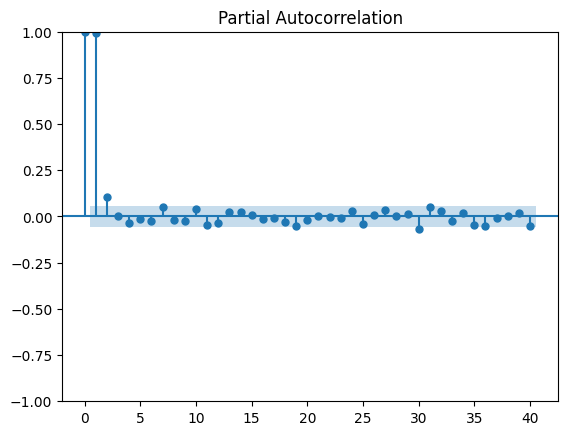

In [260]:
plot_pacf(df['Close'], lags=40)
plt.show()

C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

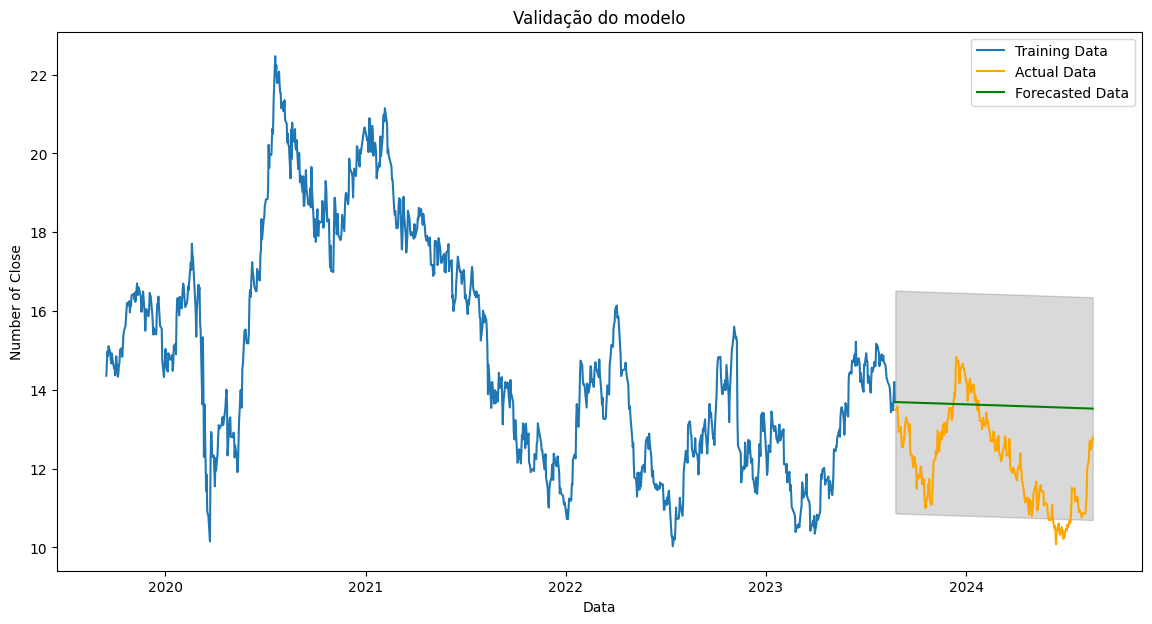

RMSE: 1.8118062186767785


In [261]:
# Split the data into train and test
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['Close'], order=(0,2,1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(list(test_forecast.predicted_mean), index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['Close'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast_series + np.std(df)['Close'], 
                 test_forecast_series - np.std(df)['Close'], 
                 color='k', alpha=.15)
plt.title('Validação do modelo')
plt.xlabel('Data')
plt.ylabel('Number of Close')
plt.legend()
plt.show()

print('RMSE:', rmse)